In [40]:
import awkward as ak
import numpy
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

fname = "/hdfs/store/user/kaho/NanoPost_2017/SingleMuon/SingleMuon_Run2017B-UL2017/210817_172749/0000/tree_1.root"#/hdfs/store/user/kaho/NanoPost_2017/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/TTTo2L2Nu/210816_193359/0000/tree_1.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:2

In [2]:
def pZeta(leg1, leg2, MET_px, MET_py):
    leg1x = numpy.cos(leg1.phi)
    leg2x = numpy.cos(leg2.phi)
    leg1y = numpy.sin(leg1.phi)
    leg2y = numpy.sin(leg2.phi)
    zetaX = leg1x + leg2x
    zetaY = leg1y + leg2y
    zetaR = numpy.sqrt(zetaX*zetaX + zetaY*zetaY)
    
    numpy.where((zetaR > 0.), zetaX/zetaR, zetaX)
    numpy.where((zetaR > 0.), zetaY/zetaR, zetaY)
    zetaX = zetaX/zetaR
    zetaY = zetaY/zetaR
    
    visPx = leg1.px + leg2.px
    visPy = leg1.py + leg2.py
    pZetaVis = visPx*zetaX + visPy*zetaY
    px = visPx + MET_px
    py = visPy + MET_py
    
    pZeta = px*zetaX + py*zetaY
    
    return (pZeta, pZetaVis)

def Rpt(lep1, lep2, jets=None):
    emVar = lep1+lep2
    if jets==None:
        return (emVar).pt/(lep1.pt+lep2.pt)
    elif len(jets)==1:
        return (emVar + jets[0]).pt/(lep1.pt+lep2.pt+jets[0].pt)
    elif len(jets)==2:
        return (emVar + jets[0] +jets[1]).pt/(lep1.pt+lep2.pt+jets[0].pt+jets[1].pt)
    else:
        return -999
    
def Zeppenfeld(lep1, lep2, jets):
    emVar = lep1+lep2
    if len(jets)==1:
        return emVar.eta - (jets[0].eta)/2
    elif len(jets)==2:
        return emVar.eta - (jets[0].eta + jets[1].eta)/2
    else:
        return -999

def mT(lep, met):
    return numpy.sqrt(abs((numpy.sqrt(lep.mass**2+lep.pt**2) + met.pt)**2 - (lep+met).pt**2))

def pt_cen(lep1, lep2, jets):
    emVar = lep1+lep2
    if len(jets)==1:
        return emVar.pt - jets[0].pt/2
    elif len(jets)==2:
        return emVar.pt - (jets[0] + jets[1]).pt/2
    else:
        return -999
        

In [43]:
#Choice em channel and Iso27
emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

E_collections = emevents.Electron
M_collections = emevents.Muon

#Kinematics Selections
emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.pfRelIso03_all < 0.1) & (E_collections.lostHits<2))
emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

E_collections = emevents.Electron[emevents.Electron.Target==1]
M_collections = emevents.Muon[emevents.Muon.Target==1]

#Opposite Charge
E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
opp_charge = ak.flatten(E_charge*M_charge==-1)

emevents = emevents[opp_charge]

#Trig Matching
M_collections = emevents.Muon
trg_collections = emevents.TrigObj
M_collections = M_collections[M_collections.Target==1]
trg_collections = trg_collections[(((trg_collections.filterBits >> 3) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1) ]

trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)

emevents = emevents[trg_Match]

print(emevents)

Electron_collections = emevents.Electron[emevents.Electron.Target==1]
Muon_collections = emevents.Muon[emevents.Muon.Target==1]

MET_collections = emevents.MET
Jet_collections = emevents.Jet[emevents.Jet.passJet30ID==1]
L_bJet_collections = emevents.Jet[emevents.Jet.passDeepJet_L==1]
M_bJet_collections = emevents.Jet[emevents.Jet.passDeepJet_M==1]

#Jet corrections
Jet_collections['pt'] = Jet_collections['pt_nom']
Jet_collections['mass'] = Jet_collections['mass_nom']

# Jet_collections['passJet30ID_v5'] = ((Jet_collections.pt>30) & (Jet_collections.jetId>>1) & 1) & (abs(Jet_collections.eta)<4.7) & (((Jet_collections.puId>>2)&1) | (Jet_collections.pt > 50)) & (Jet_collections.delta_r(Muon_collections[:,0]) > 0.4) & (Jet_collections.delta_r(Electron_collections[:,0]) > 0.4)
# Jet_collections = Jet_collections[Jet_collections.passJet30ID_v5==1]
#ensure Jets are pT-ordered
Jet_collections = Jet_collections[ak.argsort(Jet_collections.pt, axis=1, ascending=False)]
# L_bJet_collections = L_bJet_collections[ak.argsort(L_bJet_collections.pt, axis=1, ascending=False)]
# M_bJet_collections = M_bJet_collections[ak.argsort(M_bJet_collections.pt, axis=1, ascending=False)]

# Jet_collections2 = emevents.Jet[emevents.Jet.passJet30ID==1]
# Jet_collections2 = Jet_collections2[ak.argsort(Jet_collections2.pt_nom, axis=1, ascending=False)]

# #MET corrections T1Smear
# MET_collections['phi'] = MET_collections['T1Smear_phi'] 
# MET_collections['pt'] = MET_collections['T1Smear_pt']

# #MET corrections Electron
#print(MET_collections['pt'])

# Mets = ak.zip({
#             "pt": emevents.MET.T1Smear_pt,
#             "eta": numpy.zeros(len(emevents.MET.T1Smear_pt)),
#             "phi": emevents.MET.T1Smear_phi,
#             "E": emevents.MET.T1Smear_pt,
#         }, with_name="PtEtaPhiECandidate")
# Electrons = ak.zip({
#             "pt": Electron_collections['pt'],
#             "eta": Electron_collections['eta'],
#             "phi": Electron_collections['phi'],
#             "mass": Electron_collections['mass'],
#         }, with_name="PtEtaPhiMCandidate")
# print(Mets.pt)
# Mets = Mets + Electron_collections[:,0]
# Electron_collections['pt'] = Electron_collections['pt']/Electron_collections['eCorr']
# Electron_collections['pt'] = 0
# Electron_collections['eta'] = 0
# Electron_collections['phi'] = 0
# Electron_collections['mass'] = 0
# print(MET_collections.pt)
# Electron_collections['pt'] = Electron_collections['pt']/Electron_collections['eCorr']
# MET_collections = MET_collections+Electron_collections[:,0]
# print(MET_collections.pt)
# Electron_collections['pt'] = Electron_collections['pt']*Electron_collections['eCorr']
# MET_collections = MET_collections-Electron_collections[:,0]
# print(numpy.sqrt(MET_collections.x**2 + MET_collections.y**2))
#print(Mets.pt)
# #Muon pT corrections
# MET_collections = MET_collections+Muon_collections[:,0]
# Muon_collections['pt'] = Muon_collections['corrected_pt']
# MET_collections = MET_collections-Muon_collections[:,0]

#Take the first leptons
Electron_collections = Electron_collections[:,0]
Muon_collections = Muon_collections[:,0]

emVar = Electron_collections + Muon_collections
print(ak.sum(emevents.Jet.passDeepJet_L,1))

# #one hot encoding for year 
# emevents["year2016preVFP"] = numpy.zeros(len(emevents))
# emevents["year2016postVFP"] = numpy.zeros(len(emevents))
# emevents["year2017"] = numpy.ones(len(emevents))
# emevents["year2018"] = numpy.zeros(len(emevents))

# #label signal
# emevents["label"] = numpy.ones(len(emevents)) if 'LFV' in fname else numpy.zeros(len(emevents))

# var_ = ["met", "eEta", "mEta", "mpt_Per_e_m_Mass", "ept_Per_e_m_Mass", "empt", "emEta", "DeltaEta_e_m", "DeltaPhi_e_m", "DeltaR_e_m", "Rpt_0", "e_met_mT", "m_met_mT", "e_met_mT_Per_e_m_Mass", "m_met_mT_Per_e_m_Mass", "pZeta85", "pZeta15", "pZeta", "pZetaVis"]
# var_1jet_ = ["j1pt", "j1Eta", "DeltaEta_j1_em", "DeltaPhi_j1_em", "DeltaR_j1_em", "Zeppenfeld", "Rpt_1"]
# var_2jet_ = ["j2pt", "j2Eta", "j1_j2_mass", "DeltaEta_em_j1j2", "DeltaPhi_em_j1j2", "DeltaR_em_j1j2", "DeltaEta_j1_em", "DeltaPhi_j1_em", "DeltaR_j1_em", "DeltaEta_j2_em", "DeltaPhi_j2_em", "DeltaR_j2_em", "DeltaEta_j1_j2", "DeltaPhi_j1_j2", "DeltaR_j1_j2", "Zeppenfeld", "Zeppenfeld_DeltaEta", "absZeppenfeld_DeltaEta", "cen", "Rpt", "pt_cen", "pt_cen_Deltapt", "abspt_cen_Deltapt", "Ht_had", "Ht"]

# #make interesting variables
# #zero/any no. of jets
# emevents["eEta"] = Electron_collections.eta
# emevents["mEta"] = Muon_collections.eta
# emevents["mpt_Per_e_m_Mass"] = Muon_collections.pt/emVar.mass
# emevents["ept_Per_e_m_Mass"] = Electron_collections.pt/emVar.mass
# emevents["empt"] = emVar.pt
# emevents["emEta"] = emVar.eta
# emevents["DeltaEta_e_m"] = abs(Muon_collections.eta - Electron_collections.eta)
# emevents["DeltaPhi_e_m"] = Muon_collections.delta_phi(Electron_collections)
# emevents["DeltaR_e_m"] = Muon_collections.delta_r(Electron_collections)
# emevents["Rpt_0"] = Rpt(Muon_collections, Electron_collections)

# emevents["met"] = MET_collections.pt

# emevents["e_met_mT"] = mT(Electron_collections, MET_collections)
# emevents["m_met_mT"] = mT(Muon_collections, MET_collections)
# emevents["e_met_mT_Per_e_m_Mass"] = emevents["e_met_mT"]/emVar.mass
# emevents["m_met_mT_Per_e_m_Mass"] = emevents["m_met_mT"]/emVar.mass

# pZeta_, pZetaVis_ = pZeta(Muon_collections, Electron_collections,  MET_collections.px,  MET_collections.py)
# emevents["pZeta85"] = pZeta_ - 0.85*pZetaVis_
# emevents["pZeta15"] = pZeta_ - 1.5*pZetaVis_
# emevents["pZeta"] = pZeta_
# emevents["pZetaVis"] = pZetaVis_

# #one jets
# onejets_emevents = emevents[emevents.nJet30 >= 1]
# Electron_collections_1jet = Electron_collections[emevents.nJet30 >= 1]
# Muon_collections_1jet = Muon_collections[emevents.nJet30 >= 1]
# emVar_1jet = Electron_collections_1jet + Muon_collections_1jet

# onejets_emevents['j1pt'] = Jet_collections[emevents.nJet30 >= 1][:,0].pt
# onejets_emevents['j1Eta'] = Jet_collections[emevents.nJet30 >= 1][:,0].eta

# onejets_emevents["DeltaEta_j1_em"] = abs(Jet_collections[emevents.nJet30 >= 1][:,0].eta - emVar_1jet.eta)
# onejets_emevents["DeltaPhi_j1_em"] = Jet_collections[emevents.nJet30 >= 1][:,0].delta_phi(emVar_1jet)
# onejets_emevents["DeltaR_j1_em"] = Jet_collections[emevents.nJet30 >= 1][:,0].delta_r(emVar_1jet)

# onejets_emevents["Zeppenfeld"] = Zeppenfeld(Muon_collections_1jet, Electron_collections_1jet, [Jet_collections[emevents.nJet30 >= 1][:,0]])
# onejets_emevents["Rpt_1"] = Rpt(Muon_collections_1jet, Electron_collections_1jet, [Jet_collections[emevents.nJet30 >= 1][:,0]])

# #2 or more jets
# Multijets_emevents = emevents[emevents.nJet30 >= 2]

# Electron_collections_2jet = Electron_collections[emevents.nJet30 >= 2]
# Muon_collections_2jet = Muon_collections[emevents.nJet30 >= 2]
# emVar_2jet = Electron_collections_2jet + Muon_collections_2jet

# MET_collections_2jet = MET_collections[emevents.nJet30 >= 2]

# Multijets_emevents['j2pt'] = Jet_collections[emevents.nJet30 >= 2][:,1].pt
# Multijets_emevents['j2Eta'] = Jet_collections[emevents.nJet30 >= 2][:,1].eta
# Multijets_emevents["j1_j2_mass"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).mass

# Multijets_emevents["DeltaEta_em_j1j2"] = abs((Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).eta - emVar_2jet.eta)
# Multijets_emevents["DeltaPhi_em_j1j2"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).delta_phi(emVar_2jet)
# Multijets_emevents["DeltaR_em_j1j2"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).delta_r(emVar_2jet)

# Multijets_emevents["DeltaEta_j1_em"] = abs(Jet_collections[emevents.nJet30 >= 2][:,0].eta - emVar_2jet.eta)
# Multijets_emevents["DeltaPhi_j1_em"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_phi(emVar_2jet)
# Multijets_emevents["DeltaR_j1_em"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_r(emVar_2jet)
# Multijets_emevents["DeltaEta_j2_em"] = abs(Jet_collections[emevents.nJet30 >= 2][:,1].eta - emVar_2jet.eta)
# Multijets_emevents["DeltaPhi_j2_em"] = Jet_collections[emevents.nJet30 >= 2][:,1].delta_phi(emVar_2jet)
# Multijets_emevents["DeltaR_j2_em"] = Jet_collections[emevents.nJet30 >= 2][:,1].delta_r(emVar_2jet)

# Multijets_emevents["DeltaEta_j1_j2"] = abs(Jet_collections[emevents.nJet30 >= 2][:,0].eta - Jet_collections[emevents.nJet30 >= 2][:,1].eta)
# Multijets_emevents["DeltaPhi_j1_j2"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_phi(Jet_collections[emevents.nJet30 >= 2][:,1])
# Multijets_emevents["DeltaR_j1_j2"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_r(Jet_collections[emevents.nJet30 >= 2][:,1])

# Multijets_emevents["Zeppenfeld"] = Zeppenfeld(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])
# Multijets_emevents["Zeppenfeld_DeltaEta"] = Multijets_emevents["Zeppenfeld"]/Multijets_emevents["DeltaEta_j1_j2"]
# Multijets_emevents["absZeppenfeld_DeltaEta"] = abs(Multijets_emevents["Zeppenfeld_DeltaEta"])
# Multijets_emevents["cen"] = numpy.exp(-4*Multijets_emevents["Zeppenfeld_DeltaEta"]**2)

# Multijets_emevents["Rpt"] = Rpt(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])

# Multijets_emevents["pt_cen"] = pt_cen(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])
# Multijets_emevents["pt_cen_Deltapt"] = Multijets_emevents["pt_cen"]/(Jet_collections[emevents.nJet30 >= 2][:,0] - Jet_collections[emevents.nJet30 >= 2][:,1]).pt
# Multijets_emevents["abspt_cen_Deltapt"] = abs(Multijets_emevents["pt_cen_Deltapt"])

# Multijets_emevents["Ht_had"] = ak.sum(Jet_collections[emevents.nJet30 >= 2].pt, 1) + Muon_collections_2jet.pt + Electron_collections_2jet.pt
# Multijets_emevents["Ht"] = ak.sum(Jet_collections[emevents.nJet30 >= 2].pt, 1) + Muon_collections_2jet.pt + Electron_collections_2jet.pt

# #Get bTag SF
# bTagSF_M = ak.prod(1-emevents.Jet.btagSF_deepjet_M*emevents.Jet.passDeepJet_M, axis=1)
# #PU/PF/Gen Weights
# SF = emevents.puWeight*emevents.PrefireWeight*emevents.genWeight
# print(SF)

# #Muon SF
# SF = SF*Muon_collections.Trigger_SF*Muon_collections.ID_SF*Muon_collections.ISO_SF
# print(SF)

# #Electron SF
# SF = SF*Electron_collections.Reco_SF*Electron_collections.ID_SF

# print(bTagSF_M)
# print(SF)
# emevents["SF"] = SF
#emu = Electron_collections[:,0] + Muon_collections[:,0]


[<event 297050:279:355952072>, ... <event 297178:902:1089872066>]
[1, 2, 1, 2, 2, 1, 3, 3, 0, 1, 2, 0, 2, 0, ... 3, 2, 2, 2, 1, 1, 2, 2, 0, 1, 1, 1, 0]


In [ ]:
from numba import jit
import numpy as np
import time
import numba
print(numba.__version__)
@jit(nopython=True)
def DeltaEta(eta1, eta2):
    return np.absolute(eta1 - eta2)
def DeltaEta2(eta1, eta2):
    return abs(eta1 - eta2)

In [109]:
# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
DeltaEta(Jet_collections[emevents.nJet30 >= 2][:,0].eta.to_numpy(), Jet_collections[emevents.nJet30 >= 2][:,1].eta.to_numpy())
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
DeltaEta(Jet_collections[emevents.nJet30 >= 2][:,0].eta.to_numpy(), Jet_collections[emevents.nJet30 >= 2][:,1].eta.to_numpy())
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

# Without Numba
start = time.time()
DeltaEta2(Jet_collections[emevents.nJet30 >= 2][:,0].eta, Jet_collections[emevents.nJet30 >= 2][:,1].eta)
end = time.time()
print("Elapsed (no numba) = %s" % (end - start))

Elapsed (with compilation) = 0.33891773223876953
Elapsed (after compilation) = 0.02211284637451172
Elapsed (no numba) = 0.027369976043701172


In [90]:
from numba import jit
import numpy as np
import time

@jit(nopython=True)
def pZeta(leg1phi, leg1px, leg1py, leg2phi, leg2px, leg2py, MET_px, MET_py):
    leg1x = np.cos(leg1phi)
    leg2x = np.cos(leg2phi)
    leg1y = np.sin(leg1phi)
    leg2y = np.sin(leg2phi)
    zetaX = leg1x + leg2x
    zetaY = leg1y + leg2y
    zetaR = np.sqrt(zetaX*zetaX + zetaY*zetaY)
    
    np.where((zetaR > 0.), zetaX/zetaR, zetaX)
    np.where((zetaR > 0.), zetaY/zetaR, zetaY)
    zetaX = zetaX/zetaR
    zetaY = zetaY/zetaR
    
    visPx = leg1px + leg2px
    visPy = leg1py + leg2py
    pZetaVis = visPx*zetaX + visPy*zetaY
    px = visPx + MET_px
    py = visPy + MET_py
    
    pZeta = px*zetaX + py*zetaY
    
    return (pZeta, pZetaVis)

def pZeta2(leg1, leg2, MET_px, MET_py):
    leg1x = np.cos(leg1.phi)
    leg2x = np.cos(leg2.phi)
    leg1y = np.sin(leg1.phi)
    leg2y = np.sin(leg2.phi)
    zetaX = leg1x + leg2x
    zetaY = leg1y + leg2y
    zetaR = np.sqrt(zetaX*zetaX + zetaY*zetaY)
    
    np.where((zetaR > 0.), zetaX/zetaR, zetaX)
    np.where((zetaR > 0.), zetaY/zetaR, zetaY)
    zetaX = zetaX/zetaR
    zetaY = zetaY/zetaR
    
    visPx = leg1.px + leg2.px
    visPy = leg1.py + leg2.py
    pZetaVis = visPx*zetaX + visPy*zetaY
    px = visPx + MET_px
    py = visPy + MET_py
    
    pZeta = px*zetaX + py*zetaY
    
    return (pZeta, pZetaVis)

# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
pZeta(Muon_collections.phi.to_numpy(), Muon_collections.px.to_numpy(), Muon_collections.py.to_numpy(), Electron_collections.phi.to_numpy(),  Electron_collections.px.to_numpy(), Electron_collections.py.to_numpy(), MET_collections.px.to_numpy(),  MET_collections.py.to_numpy())
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
pZeta(Muon_collections.phi.to_numpy(), Muon_collections.px.to_numpy(), Muon_collections.py.to_numpy(), Electron_collections.phi.to_numpy(),  Electron_collections.px.to_numpy(), Electron_collections.py.to_numpy(), MET_collections.px.to_numpy(),  MET_collections.py.to_numpy())
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

# Without Numba
start = time.time()
pZeta2(Muon_collections, Electron_collections, MET_collections.px,  MET_collections.py)
end = time.time()
print("Elapsed (no numba) = %s" % (end - start))

Elapsed (with compilation) = 2.880722999572754
Elapsed (after compilation) = 0.06871509552001953
Elapsed (no numba) = 0.14662694931030273


In [5]:
#Write csv files
import pandas as pd
from coffea import processor

#0jets
var_dict = {}
for var in var_ :
  var_dict[var] = ak.to_list(emevents[emevents.nJet30 == 1][var])
df = pd.DataFrame(var_dict)
df.to_csv('out_0jets.csv')

#1jets
var_dict = {}
for var in var_ :
  var_dict[var] = ak.to_list(emevents[emevents.nJet30 >= 1][var])
for var in var_1jet_ :
  var_dict[var] = ak.to_list(onejets_emevents[var])
df = pd.DataFrame(var_dict)
df.to_csv('out_1jets.csv')

#2jets
var_dict = {}
for var in var_ :
  var_dict[var] = ak.to_list(emevents[emevents.nJet30 >= 2][var])
for var in var_1jet_ :
  var_dict[var] = ak.to_list(onejets_emevents[onejets_emevents.nJet30 >= 2][var])
for var in var_2jet_ :
  var_dict[var] = ak.to_list(Multijets_emevents[var])
df = pd.DataFrame(var_dict)
df.to_csv('out_2jets.csv')



In [4]:
del events
del emevents
del emu

NameError: name 'emu' is not defined

In [5]:
from coffea import processor
import numpy
class MyDF(processor.ProcessorABC):
    def __init__(self, lumiWeight):
        self._lumiWeight = lumiWeight
        self._accumulator = processor.dict_accumulator({})
        self.var_ = ["label", "weight", "met", "eEta", "mEta", "mpt_Per_e_m_Mass", "ept_Per_e_m_Mass", "empt", "emEta", "DeltaEta_e_m", "DeltaPhi_e_m", "DeltaR_e_m", "Rpt_0", "e_met_mT", "m_met_mT", "e_met_mT_Per_e_m_Mass", "m_met_mT_Per_e_m_Mass", "pZeta85", "pZeta15", "pZeta", "pZetaVis"]
        self.var_1jet_ = ["j1pt", "j1Eta", "DeltaEta_j1_em", "DeltaPhi_j1_em", "DeltaR_j1_em", "Zeppenfeld_1", "Rpt_1"]
        self.var_2jet_ = ["j2pt", "j2Eta", "j1_j2_mass", "DeltaEta_em_j1j2", "DeltaPhi_em_j1j2", "DeltaR_em_j1j2", "DeltaEta_j2_em", "DeltaPhi_j2_em", "DeltaR_j2_em", "DeltaEta_j1_j2", "DeltaPhi_j1_j2", "DeltaR_j1_j2", "Zeppenfeld", "Zeppenfeld_DeltaEta", "absZeppenfeld_DeltaEta", "cen", "Rpt", "pt_cen", "pt_cen_Deltapt", "abspt_cen_Deltapt", "Ht_had", "Ht"]
        for var in self.var_ :
            self._accumulator[var+'_0jets'] = processor.column_accumulator(numpy.array([]))
            self._accumulator[var+'_1jets'] = processor.column_accumulator(numpy.array([]))
            self._accumulator[var+'_2jets'] = processor.column_accumulator(numpy.array([]))
        for var in self.var_1jet_ :
            self._accumulator[var+'_1jets'] = processor.column_accumulator(numpy.array([]))
            self._accumulator[var+'_2jets'] = processor.column_accumulator(numpy.array([]))
        for var in self.var_2jet_ :
            self._accumulator[var+'_2jets'] = processor.column_accumulator(numpy.array([]))
    @property
    def accumulator(self):
        return self._accumulator
    
    def Corrections(self, emevents):
        Electron_collections = emevents.Electron[emevents.Electron.Target==1]
        Muon_collections = emevents.Muon[emevents.Muon.Target==1]
        MET_collections = emevents.MET
        Jet_collections = emevents.Jet[emevents.Jet.passJet30ID==1]

        #ensure Jets are pT-ordered
        if emevents.metadata["dataset"]!='data':
            #Jet corrections
            Jet_collections['pt'] = Jet_collections['pt_nom']
            Jet_collections['mass'] = Jet_collections['mass_nom']
            #MET pT corrections
            MET_collections['phi'] = MET_collections['T1Smear_phi'] 
            MET_collections['pt'] = MET_collections['T1Smear_pt'] \
                                    - ak.flatten(Muon_collections['pt']) + ak.flatten(Muon_collections['corrected_pt'])\
                                    - ak.flatten(Electron_collections['pt']/Electron_collections['eCorr'])\
                                    + ak.flatten(Electron_collections['pt'])

            #Muon pT corrections
            Muon_collections['pt'] = Muon_collections['corrected_pt']
        
        #ensure Jets are pT-ordered
        Jet_collections = Jet_collections[ak.argsort(Jet_collections.pt, axis=1, ascending=False)]

        #Take the first leptons
        Electron_collections = Electron_collections[:,0]
        Muon_collections = Muon_collections[:,0]
        emVar = Electron_collections + Muon_collections
        massRange = (emVar.mass<160) & (emVar.mass>110)
        
        return emevents[massRange], Electron_collections[massRange], Muon_collections[massRange], MET_collections[massRange], Jet_collections[massRange]
    

    def Vetos(self, events):
        #Choice em channel and Iso27
        emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

        E_collections = emevents.Electron
        M_collections = emevents.Muon

        #Kinematics Selections
        emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.pfRelIso03_all < 0.1))
        emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

        E_collections = emevents.Electron[emevents.Electron.Target==1]
        M_collections = emevents.Muon[emevents.Muon.Target==1]

        #Opposite Charge
        E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
        M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
        opp_charge = ak.flatten(E_charge*M_charge==-1)

        emevents = emevents[opp_charge]

        #Trig Matching
        M_collections = emevents.Muon
        trg_collections = emevents.TrigObj

        M_collections = M_collections[M_collections.Target==1]
        trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

        trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)

        return emevents[trg_Match]
    
    def SF(self, emevents):
        if emevents.metadata["dataset"]=='data': return numpy.ones(len(emevents))
        #Get bTag SF
        bTagSF_L = ak.prod(1-emevents.Jet.btagSF_deepjet_L*emevents.Jet.passDeepJet_L, axis=1)
        bTagSF_M = ak.prod(1-emevents.Jet.btagSF_deepjet_M*emevents.Jet.passDeepJet_M, axis=1)

        #PU/PF/Gen Weights
        SF = emevents.puWeight*emevents.PrefireWeight*emevents.genWeight

        Muon_collections = emevents.Muon[emevents.Muon.Target==1]
        Electron_collections = emevents.Electron[emevents.Electron.Target==1]
        
        #Muon SF
        SF = SF*Muon_collections.Trigger_SF*Muon_collections.ID_SF*Muon_collections.ISO_SF

        #Electron SF
        SF = SF*Electron_collections.Reco_SF*Electron_collections.ID_SF
        
        emevents["weight"] = ak.flatten(SF)*self._lumiWeight[emevents.metadata["dataset"]]
        emevents["label"] = numpy.ones(len(emevents), dtype=numpy.bool_) if 'LFV' in emevents.metadata["dataset"] else numpy.zeros(len(emevents), dtype=numpy.bool_)
        
        return emevents
    
    def interesting(self, emevents, Electron_collections, Muon_collections, MET_collections, Jet_collections):
        #make interesting variables
        #zero/any no. of jets
        #Take the first leptons
        emVar = Electron_collections + Muon_collections
        emevents["eEta"] = Electron_collections.eta
        emevents["mEta"] = Muon_collections.eta
        emevents["mpt_Per_e_m_Mass"] = Muon_collections.pt/emVar.mass
        emevents["ept_Per_e_m_Mass"] = Electron_collections.pt/emVar.mass
        emevents["empt"] = emVar.pt
        emevents["emEta"] = emVar.eta
        emevents["DeltaEta_e_m"] = abs(Muon_collections.eta - Electron_collections.eta)
        emevents["DeltaPhi_e_m"] = Muon_collections.delta_phi(Electron_collections)
        emevents["DeltaR_e_m"] = Muon_collections.delta_r(Electron_collections)
        emevents["Rpt_0"] = Rpt(Muon_collections, Electron_collections)

        emevents["met"] = MET_collections.pt

        emevents["e_met_mT"] = mT(Electron_collections, MET_collections)
        emevents["m_met_mT"] = mT(Muon_collections, MET_collections)
        emevents["e_met_mT_Per_e_m_Mass"] = emevents["e_met_mT"]/emVar.mass
        emevents["m_met_mT_Per_e_m_Mass"] = emevents["m_met_mT"]/emVar.mass

        pZeta_, pZetaVis_ = pZeta(Muon_collections, Electron_collections,  MET_collections.px,  MET_collections.py)
        emevents["pZeta85"] = pZeta_ - 0.85*pZetaVis_
        emevents["pZeta15"] = pZeta_ - 1.5*pZetaVis_
        emevents["pZeta"] = pZeta_
        emevents["pZetaVis"] = pZetaVis_

        #one jets
        onejets_emevents = emevents[emevents.nJet30 >= 1]
        Electron_collections_1jet = Electron_collections[emevents.nJet30 >= 1]
        Muon_collections_1jet = Muon_collections[emevents.nJet30 >= 1]
        emVar_1jet = Electron_collections_1jet + Muon_collections_1jet

        onejets_emevents['j1pt'] = Jet_collections[emevents.nJet30 >= 1][:,0].pt
        onejets_emevents['j1Eta'] = Jet_collections[emevents.nJet30 >= 1][:,0].eta

        onejets_emevents["DeltaEta_j1_em"] = abs(Jet_collections[emevents.nJet30 >= 1][:,0].eta - emVar_1jet.eta)
        onejets_emevents["DeltaPhi_j1_em"] = Jet_collections[emevents.nJet30 >= 1][:,0].delta_phi(emVar_1jet)
        onejets_emevents["DeltaR_j1_em"] = Jet_collections[emevents.nJet30 >= 1][:,0].delta_r(emVar_1jet)

        onejets_emevents["Zeppenfeld_1"] = Zeppenfeld(Muon_collections_1jet, Electron_collections_1jet, [Jet_collections[emevents.nJet30 >= 1][:,0]])
        onejets_emevents["Rpt_1"] = Rpt(Muon_collections_1jet, Electron_collections_1jet, [Jet_collections[emevents.nJet30 >= 1][:,0]])

        #2 or more jets
        Multijets_emevents = emevents[emevents.nJet30 >= 2]

        Electron_collections_2jet = Electron_collections[emevents.nJet30 >= 2]
        Muon_collections_2jet = Muon_collections[emevents.nJet30 >= 2]
        emVar_2jet = Electron_collections_2jet + Muon_collections_2jet

        MET_collections_2jet = MET_collections[emevents.nJet30 >= 2]

        Multijets_emevents['j2pt'] = Jet_collections[emevents.nJet30 >= 2][:,1].pt
        Multijets_emevents['j2Eta'] = Jet_collections[emevents.nJet30 >= 2][:,1].eta
        Multijets_emevents["j1_j2_mass"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).mass

        Multijets_emevents["DeltaEta_em_j1j2"] = abs((Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).eta - emVar_2jet.eta)
        Multijets_emevents["DeltaPhi_em_j1j2"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).delta_phi(emVar_2jet)
        Multijets_emevents["DeltaR_em_j1j2"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).delta_r(emVar_2jet)

        Multijets_emevents["DeltaEta_j1_em"] = abs(Jet_collections[emevents.nJet30 >= 2][:,0].eta - emVar_2jet.eta)
        Multijets_emevents["DeltaPhi_j1_em"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_phi(emVar_2jet)
        Multijets_emevents["DeltaR_j1_em"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_r(emVar_2jet)
        Multijets_emevents["DeltaEta_j2_em"] = abs(Jet_collections[emevents.nJet30 >= 2][:,1].eta - emVar_2jet.eta)
        Multijets_emevents["DeltaPhi_j2_em"] = Jet_collections[emevents.nJet30 >= 2][:,1].delta_phi(emVar_2jet)
        Multijets_emevents["DeltaR_j2_em"] = Jet_collections[emevents.nJet30 >= 2][:,1].delta_r(emVar_2jet)

        Multijets_emevents["DeltaEta_j1_j2"] = abs(Jet_collections[emevents.nJet30 >= 2][:,0].eta - Jet_collections[emevents.nJet30 >= 2][:,1].eta)
        Multijets_emevents["DeltaPhi_j1_j2"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_phi(Jet_collections[emevents.nJet30 >= 2][:,1])
        Multijets_emevents["DeltaR_j1_j2"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_r(Jet_collections[emevents.nJet30 >= 2][:,1])

        Multijets_emevents["Zeppenfeld"] = Zeppenfeld(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])
        Multijets_emevents["Zeppenfeld_DeltaEta"] = Multijets_emevents["Zeppenfeld"]/Multijets_emevents["DeltaEta_j1_j2"]
        Multijets_emevents["absZeppenfeld_DeltaEta"] = abs(Multijets_emevents["Zeppenfeld_DeltaEta"])
        Multijets_emevents["cen"] = numpy.exp(-4*Multijets_emevents["Zeppenfeld_DeltaEta"]**2)

        Multijets_emevents["Rpt"] = Rpt(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])

        Multijets_emevents["pt_cen"] = pt_cen(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])
        Multijets_emevents["pt_cen_Deltapt"] = Multijets_emevents["pt_cen"]/(Jet_collections[emevents.nJet30 >= 2][:,0] - Jet_collections[emevents.nJet30 >= 2][:,1]).pt
        Multijets_emevents["abspt_cen_Deltapt"] = abs(Multijets_emevents["pt_cen_Deltapt"])

        Multijets_emevents["Ht_had"] = ak.sum(Jet_collections[emevents.nJet30 >= 2].pt, 1) + Muon_collections_2jet.pt + Electron_collections_2jet.pt
        Multijets_emevents["Ht"] = ak.sum(Jet_collections[emevents.nJet30 >= 2].pt, 1) + Muon_collections_2jet.pt + Electron_collections_2jet.pt
        return emevents, onejets_emevents, Multijets_emevents

    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        emevents = self.Vetos(events)
        emevents, Electron_collections, Muon_collections, MET_collections, Jet_collections = self.Corrections(emevents)
        emevents, onejets_emevents, Multijets_emevents = self.interesting(emevents, Electron_collections, Muon_collections, MET_collections, Jet_collections)
        emevents = self.SF(emevents)
        for var in self.var_ :
            out[var+'_0jets'].add( processor.column_accumulator( emevents[emevents.nJet30 == 0][var].to_numpy() ) )

        for var in self.var_ :
            out[var+'_1jets'].add( processor.column_accumulator( emevents[emevents.nJet30 >= 1][var].to_numpy() ) )
        for var in self.var_1jet_ :
            out[var+'_1jets'].add( processor.column_accumulator( onejets_emevents[var].to_numpy() ) )

        for var in self.var_ :
            out[var+'_2jets'].add( processor.column_accumulator( emevents[emevents.nJet30 >= 2][var].to_numpy() ) )
        for var in self.var_1jet_ :
            out[var+'_2jets'].add( processor.column_accumulator( onejets_emevents[onejets_emevents.nJet30 >= 2][var].to_numpy() ) )
        for var in self.var_2jet_ :
            out[var+'_2jets'].add( processor.column_accumulator( Multijets_emevents[var].to_numpy() ) )
 
        return out

    def postprocess(self, accumulator):
        return accumulator


In [27]:
import glob
import os
import json
import time
year = '2017'
with open('../lumi_'+year+'.json') as f:
    lumiWeight = json.load(f)
ncpu = os.cpu_count()
print ("Number of cores: %i"%ncpu)

samples = {}

for samples_shorthand in lumiWeight:
    samples[samples_shorthand] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/'+samples_shorthand+'*/*/*/*/*root')

#samples['data'] = glob.glob('/hdfs/store/user/kaho/NanoPost1/SingleMuon/*/*/*/*root')

t1_start = time.time()
result = processor.run_uproot_job(
    samples,
    "Events",
    MyDF(lumiWeight),
    processor.futures_executor,
    {"schema": NanoAODSchema, "workers": os.cpu_count()},
)
t1_stop = time.time()
print("Elapsed time:", t1_stop-t1_start)

Number of cores: 24


NameError: name 'MyDF' is not defined

In [102]:
from coffea.util import load
import pandas as pd
import uproot3
var_dict = [{}, {}, {}]
var_tree = [{}, {}, {}]
result = load("results/2017/makeDF/output.coffea")[0]
for varName in result:
    if '0jets' in varName:
        var_dict[0][varName.replace('_0jets','')] = result[varName].value
        var_tree[0][varName.replace('_0jets','')] = result[varName].value.dtype
    if '1jets' in varName:
        var_dict[1][varName.replace('_1jets','')] = result[varName].value
    if '2jets' in varName:
        var_dict[2][varName.replace('_2jets','')] = result[varName].value


fout = uproot3.recreate('output.root')
fout['tree'] = uproot3.newtree(var_tree[0])
fout['tree'].extend(var_dict[0])
fout.close()
print (type(result['label_0jets'].value.dtype))
# for i in var_dict[2]:
#     print(i) 
#     print(var_dict[2][i].dtype)
# for i in range(3):
#     df = pd.DataFrame(var_dict[i])
#     df.to_csv('out_'+str(i)+'jets.csv')

<class 'numpy.dtype'>


In [60]:
from coffea import processor, hist
import numpy
class MyEMuPeak(processor.ProcessorABC):
    def __init__(self, lumiWeight):
        self._lumiWeight = lumiWeight
        self._histo = hist.Hist(
            "Events",
            hist.Cat("dataset", "samples"),
            hist.Bin("emumass", "emumass", 50, 110, 160),
        )
#         self._histo = hist.Hist(
#             "Events",
#             hist.Cat("dataset", "samples"),
#             hist.Bin("emumass", "e_mu mass", 50, 110, 160),
#             hist.Bin("ept", "e pt", 40, 24, 200),
#         )

    @property
    def accumulator(self):
        return self._histo
    
    def Vetos(self, events):
        #Choice em channel and Iso27
        emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]
        E_collections = emevents.Electron
        M_collections = emevents.Muon

        #Kinematics Selections
        emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.pfRelIso03_all < 0.1))
        emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

        E_collections = emevents.Electron[emevents.Electron.Target==1]
        M_collections = emevents.Muon[emevents.Muon.Target==1]

        #Opposite Charge
        E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
        M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
        opp_charge = ak.flatten(E_charge*M_charge==-1)

        emevents = emevents[opp_charge]

        #Trig Matching
        M_collections = emevents.Muon
        trg_collections = emevents.TrigObj

        M_collections = M_collections[M_collections.Target==1]
        trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

        trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)

        return emevents[trg_Match]
    
    def Corrections(self, emevents):
        Electron_collections = emevents.Electron[emevents.Electron.Target==1]
        Muon_collections = emevents.Muon[emevents.Muon.Target==1]
        MET_collections = emevents.MET
        
        Jet_collections = emevents.Jet
#         Jet_collections['passJet30ID_v5'] = ((Jet_collections.pt_nom>30) & (Jet_collections.jetId>>1) & 1) & (abs(Jet_collections.eta)<4.7) & (((Jet_collections.puId>>2)&1) | (Jet_collections.pt_nom > 50)) & (Jet_collections.delta_r(Muon_collections[:,0]) > 0.4) & (Jet_collections.delta_r(Electron_collections[:,0]) > 0.4)
#         Jet_collections = Jet_collections[Jet_collections.passJet30ID_v5==1]
        
#         emevents['nJet30_v5'] = ak.sum(Jet_collections['passJet30ID_v5'], 1)
        
        Jet_collections = emevents.Jet[emevents.Jet.passJet30ID==1]
        
        #Jet corrections
        Jet_collections['pt'] = Jet_collections['pt_nom']#/Jet_collections['corr_JER']
        Jet_collections['mass'] = Jet_collections['mass_nom']#/Jet_collections['corr_JER']
        
        #Muon pT corrections
        Muon_collections['pt'] = Muon_collections['corrected_pt']

#         if emevents.metadata["dataset"]!='data':
#             #MET pT corrections
#             MET_collections['phi'] = MET_collections['T1Smear_phi'] 
#             MET_collections['pt'] = MET_collections['T1Smear_pt'] \
#                                     - ak.flatten(Muon_collections['pt']) + ak.flatten(Muon_collections['corrected_pt'])\
#                                     - ak.flatten(Electron_collections['pt']/Electron_collections['eCorr'])\
#                                     + ak.flatten(Electron_collections['pt'])

        
        #ensure Jets are pT-ordered
        Jet_collections = Jet_collections[ak.argsort(Jet_collections.pt, axis=1, ascending=False)]

        #Take the first leptons
        Electron_collections = Electron_collections[:,0]
        Muon_collections = Muon_collections[:,0]
        emVar = Electron_collections + Muon_collections
        
        if 'LFV' in emevents.metadata["dataset"]:
            massRange = (emVar.mass<160) & (emVar.mass>110)
        elif emevents.metadata["dataset"]=='data':
            massRange = (((emVar.mass<115) & (emVar.mass>110)) | ((emVar.mass<160) & (emVar.mass>135))) #& (ak.sum(emevents.Jet.passDeepJet_L, 1)==0)
        else:
            massRange = (((emVar.mass<115) & (emVar.mass>110)) | ((emVar.mass<160) & (emVar.mass>135)))
        
        return emevents[massRange], Electron_collections[massRange], Muon_collections[massRange], MET_collections[massRange], Jet_collections[massRange]
    
    def SF(self, emevents):
        if emevents.metadata["dataset"]=='data': 
            return ((ak.sum(emevents.Jet.passDeepJet_L,1)==0))
        #Get bTag SF
        bTagSF_L = ak.prod(1-emevents.Jet.btagSF_deepjet_L*emevents.Jet.passDeepJet_L, axis=1)
        bTagSF_M = ak.prod(1-emevents.Jet.btagSF_deepjet_M*emevents.Jet.passDeepJet_M, axis=1)

        #PU/PF/Gen Weights
        SF = emevents.puWeight*emevents.PrefireWeight*emevents.genWeight

        Muon_collections = emevents.Muon[emevents.Muon.Target==1][:,0]
        Electron_collections = emevents.Electron[emevents.Electron.Target==1][:,0]
        
        #Muon SF
        SF = SF*Muon_collections.Trigger_SF*Muon_collections.ID_SF*Muon_collections.ISO_SF

        #Electron SF
        SF = SF*Electron_collections.Reco_SF*Electron_collections.ID_SF
        
        return SF*self._lumiWeight[emevents.metadata["dataset"]]*bTagSF_L
        
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        emevents = self.Vetos(events)
        emevents, Electron_collections, Muon_collections, MET_collections, Jet_collections = self.Corrections(emevents)
        weight = self.SF(emevents)
        emu = Electron_collections + Muon_collections
        out.fill(
            dataset=emevents.metadata["dataset"],
            emumass=emu.mass, 
            weight=weight
        )
#         out.fill(
#             dataset=emevents.metadata["dataset"],
#             j1eta=Jet_collections[emevents.nJet30 >= 1][:,0].eta, 
#             weight=weight[emevents.nJet30 >= 1]
#         )
        
#         out.fill(
#             dataset=emevents.metadata["dataset"],
#             emumass=emu.mass, 
#             ept=Electron_collections.pt,
#             weight=weight
#         )
        return out

    def postprocess(self, accumulator):
        return accumulator

In [61]:
import glob
import os
import time
import json
year = '2017'
with open('../lumi_'+year+'.json') as f:
    lumiWeight = json.load(f)
ncpu = os.cpu_count()
print ("Number of cores: %i"%ncpu)
samples = {}

# for samples_shorthand in lumiWeight:
#     samples[samples_shorthand] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/'+samples_shorthand+'*/*/*/*/*root')

#samples['GluGlu_LFV_HToEMu_M125'] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8/GluGlu_LFV_HToEMu_M125/210728_212803/*/*.root')
samples['data'] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/SingleMuon/*/*/*/*.root')
samples['TTTo2L2Nu'] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/TTTo2L2Nu/*/*/*.root')
#samples['DYJetsToLL_M-50'] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/*/*/*/*.root')

t1_start = time.time()
result = processor.run_uproot_job(
    samples,
    "Events",
    MyEMuPeak(lumiWeight),
    processor.futures_executor,
    {"schema": NanoAODSchema, "workers": os.cpu_count()},
)
t1_stop = time.time()
print("Elapsed time:", t1_stop-t1_start)

Number of cores: 24


Processing:   0%|          | 0/1016 [00:00<?, ?chunk/s]

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Tau_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Tau_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/na

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Tau_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoao

Elapsed time: 412.6686329841614


In [48]:
from coffea.util import save, load
from coffea import hist
hists = load("../results/2017/makeHist/output.coffea")

for key, h in hists[0].items():
    if not isinstance(h, hist.Hist): continue
    for dataset in h.identifiers('dataset'):
        print(dataset)
#hist.plot1d(histo[0]['j1Eta'].integrate('dataset', 'WZ_TuneCP5'))

DYJetsToLL_0J
DYJetsToLL_1J
DYJetsToLL_2J
DYJetsToLL_M-10to50
DYJetsToLL_M-50
EWKZ2Jets_ZToLL
GluGlu_LFV_HToEMu_M125
TTTo2L2Nu
TTToHadronic
TTToSemiLeptonic
VBF_LFV_HToEMu_M125
WGToLNuG_TuneCP5
WJetsToLNu_1J
WJetsToLNu_2J
WW_TuneCP5
WZ_TuneCP5
ZZ_TuneCP5
DYJetsToLL_0J
DYJetsToLL_1J
DYJetsToLL_2J
DYJetsToLL_M-10to50
DYJetsToLL_M-50
EWKZ2Jets_ZToLL
GluGlu_LFV_HToEMu_M125
TTTo2L2Nu
TTToHadronic
TTToSemiLeptonic
VBF_LFV_HToEMu_M125
WGToLNuG_TuneCP5
WJetsToLNu_1J
WJetsToLNu_2J
WW_TuneCP5
WZ_TuneCP5
ZZ_TuneCP5
DYJetsToLL_0J
DYJetsToLL_1J
DYJetsToLL_2J
DYJetsToLL_M-10to50
DYJetsToLL_M-50
EWKZ2Jets_ZToLL
GluGlu_LFV_HToEMu_M125
TTTo2L2Nu
TTToHadronic
TTToSemiLeptonic
VBF_LFV_HToEMu_M125
WGToLNuG_TuneCP5
WJetsToLNu_1J
WJetsToLNu_2J
WW_TuneCP5
WZ_TuneCP5
ZZ_TuneCP5
DYJetsToLL_0J
DYJetsToLL_1J
DYJetsToLL_2J
DYJetsToLL_M-10to50
DYJetsToLL_M-50
EWKZ2Jets_ZToLL
GluGlu_LFV_HToEMu_M125
TTTo2L2Nu
TTToHadronic
TTToSemiLeptonic
VBF_LFV_HToEMu_M125
WGToLNuG_TuneCP5
WJetsToLNu_1J
WJetsToLNu_2J
WW_TuneCP5
WZ

In [62]:
from coffea.util import save, load
save(result, "output.coffea")

<Hist (dataset,emumass) instance at 0x7f336d7fa048>
5774.0
1492.6616685580393


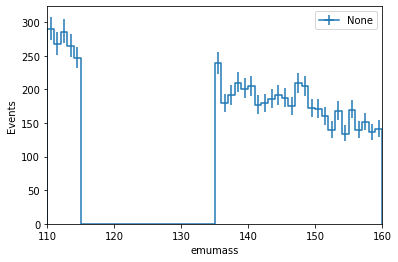

In [74]:
from coffea.util import save, load
from coffea import hist
histo = load("output.coffea")

%matplotlib inline
print(histo)
hist.plot1d(histo.integrate('dataset', 'data'))
print(histo.values()[('data',)].sum())
print(histo.values()[('TTTo2L2Nu',)].sum())
#hist.plot1d(histo.integrate('ept'))#.integrate('dataset', 'GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8'))
#hist.plot1d(histo['GluGlu_LFV_HToEMu'])
#hist.plot1d(histo.integrate('emumass')['data']) #.integrate('dataset', 'data'))

#hist.plot2d(histo.integrate('dataset'), xaxis='ept')
#print(histo.identifiers('dataset'))
#hist.plot1d(result['dataset']['GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8'].integrate('ept'))

<Hist (dataset,j1eta) instance at 0x7fcc98d947f0>


<AxesSubplot:xlabel='j1eta', ylabel='Events'>

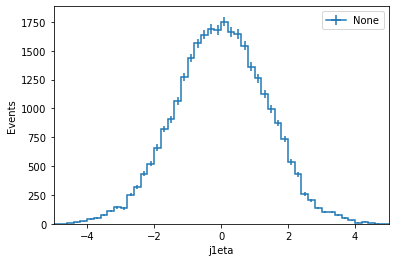

In [35]:
histo = load("output_data.coffea")

%matplotlib inline
print(histo)
hist.plot1d(histo.integrate('dataset', 'data'))

<AxesSubplot:xlabel='j1eta', ylabel='Events'>

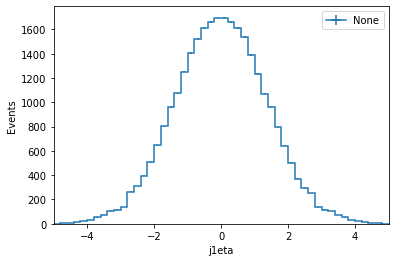

In [15]:
hist.plot1d(histo.integrate('dataset', 'TTTo2L2Nu'))

<AxesSubplot:xlabel='j1eta', ylabel='Events'>

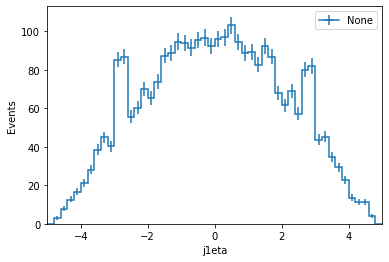

In [16]:
hist.plot1d(histo.integrate('dataset', 'GluGlu_LFV_HToEMu_M125'))

In [ ]:
import uproot3

fout = uproot3.recreate('output.root')

a = result.integrate('dataset', 'GluGlu_LFV_HToEMu').to_boost()
b = result.integrate('dataset', 'GluGlu_LFV_HToEMu').integrate('ept').to_boost()

fout['GluGlu_LFV_HToEMu_1d'] =  b.to_numpy()
fout['GluGlu_LFV_HToEMu_2d'] =  a.to_numpy()

fout.close()

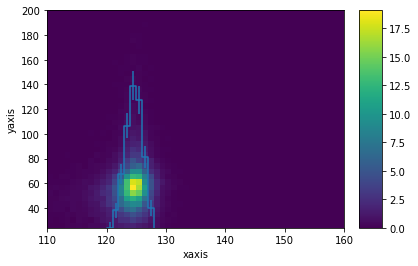

In [129]:
import uproot
fout = uproot.open('output.root')
fout['GluGlu_LFV_HToEMu_1d'].to_hist().plot()
#print(type(fout['GluGlu_LFV_HToEMu_1d'].to_hist()))
fout['GluGlu_LFV_HToEMu_2d'].to_hist().plot() #.show()
fout.close()